In [1]:
import dsds.prescreen as ps
import dsds.utils as u
import dsds.transform as t
import dsds.encoders as enc
import dsds.sample as sa
import dsds.fs as fs
import polars as pl

# More Complicated Pipelines that are Beyond Sklearn

This is a more advanced pipeline. It contains filter, upsample steps, which are compatible with the pipeline. Note however, the pipeline
does not persist the upsample step. Filter step is persisted.
You can also append a model score to the dataframe. That means this model score append can be an intermediate step, which enables pipelines in which the final model depends on previous model scores. Simple passthroughs like logistic passthrough is built in for you.

More functionalities will be added.

In [2]:
# `data` is Lazy because input is Lazy. All pipe functions work with LazyFrames
data:pl.LazyFrame = (
    pl.scan_csv("../data/advertising.csv").sort(by="id")
    .pipe(ps.drop_by_var, threshold = 0.5, target = "Clicked on Ad")
    .pipe(ps.filter, condition = pl.col("Age") > 30, persist=True)
    .pipe(ps.drop_constants)
    .pipe(enc.force_binary)
    .pipe(sa.simple_upsample, subgroup = pl.col("One_Hot_Test") != 'A', count = 200)
    .pipe(enc.one_hot_encode, cols= ["One_Hot_Test"])
    .pipe(t.impute, cols=["Area Income", "Daily Internet Usage", "Daily Internet Usage Band"], strategy="median")
    .pipe(t.impute, cols=["Daily Internet Usage"], strategy = "mean")
    .pipe(u.logistic_passthrough, col = "Daily Internet Usage", coeff=0.5, const=-100.)
    .pipe(fs.mrmr_selector, target = "Clicked on Ad", top_k = 12, strategy="fscore")
    .pipe(fs.mutual_info_selector, target = "Clicked on Ad", top_k = 3)
    .pipe(ps.drop_if_exists, ["Ad Topic Line", "City", "Country", "Timestamp"])
    .pipe(ps.rename, rename_dict={"Daily Internet Usage_logistic":"Daily Internet Usage Logistic Score"})
)


INFO:dsds.prescreen:The following columns are dropped because they have lower than 0.5 variance. ['Male', 'Test_Constant', 'Test_BadColumn'].
Removed a total of 3 columns.
INFO:dsds.prescreen:The following columns are dropped because they are constants. ['Test_Str_Constant'].
Removed a total of 1 columns.
INFO:dsds.fs:Running fscore to determine feature relevance...
INFO:dsds.fs:Found 13 total features to select from. Proceeding to select top 12 features.
MRMR, fscore: 100%|██████████| 12/12 [00:00<00:00, 11995.15it/s]
INFO:dsds.fs:Selected 12 features. There are 6 columns the algorithm cannot process. They are also returned.


Output is sorted in order of selection (max relevance min redundancy).


Mutual Info: 100%|██████████| 12/12 [00:00<00:00, 155.39it/s]
INFO:dsds.fs:Selected 3 features. There are 5 columns the algorithm cannot process. They are also returned.
INFO:dsds.prescreen:The following columns are dropped. ['City', 'Country', 'Timestamp', 'Ad Topic Line'].
Removed a total of 4 columns.


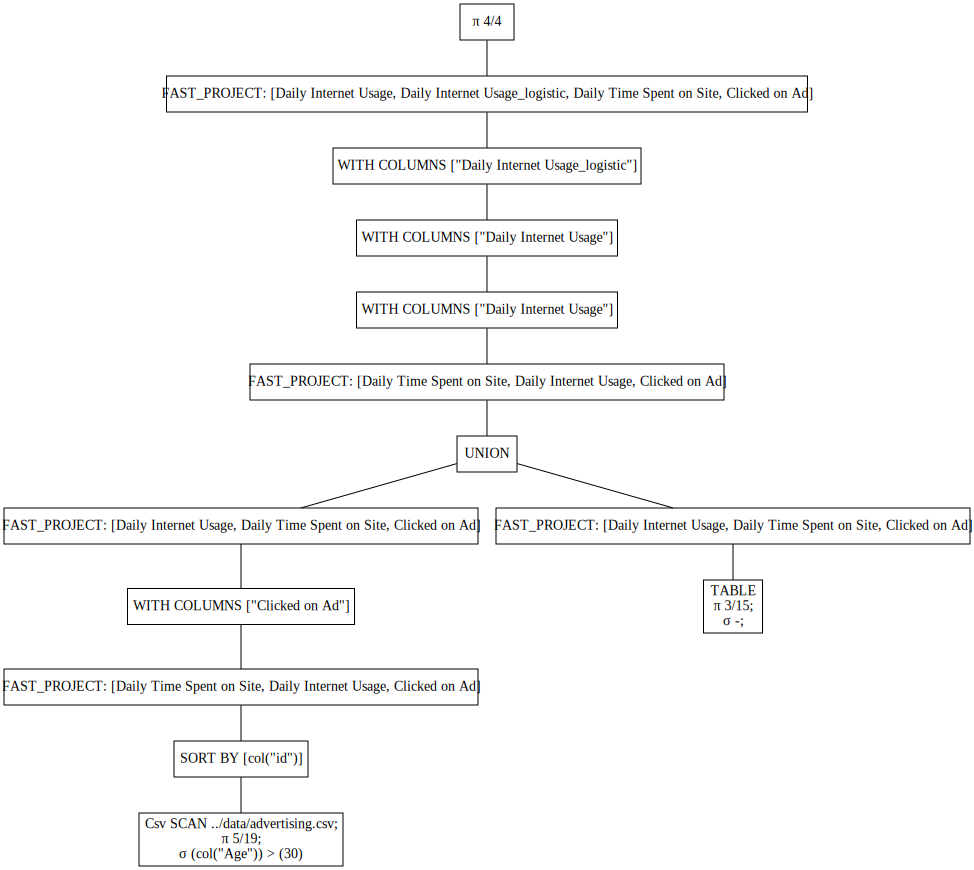

In [3]:
data.show_graph() # Polars magic! Requires graphviz package to be installed

In [4]:
print(data.explain()) # Comes for free from Polars

 SELECT [col("Daily Internet Usage"), col("Daily Internet Usage_logistic").alias("Daily Internet Usage Logistic Score"), col("Daily Time Spent on Site"), col("Clicked on Ad")] FROM
  FAST_PROJECT: [Daily Internet Usage, Daily Internet Usage_logistic, Daily Time Spent on Site, Clicked on Ad]
     WITH_COLUMNS:
     [[(1.0) / ([(1.0) + ([(-1.0) * ([([(col("Daily Internet Usage")) * (0.5)]) + (-100.0)])].exp())])].alias("Daily Internet Usage_logistic")]
       WITH_COLUMNS:
       [col("Daily Internet Usage").fill_null([171.166689])]
         WITH_COLUMNS:
         [col("Daily Internet Usage").fill_null([162.255])]
          FAST_PROJECT: [Daily Time Spent on Site, Daily Internet Usage, Clicked on Ad]
            UNION
              PLAN 0:
                FAST_PROJECT: [Daily Internet Usage, Daily Time Spent on Site, Clicked on Ad]
                   WITH_COLUMNS:
                   [.when([(col("Clicked on Ad")) == (0)]).then(0).otherwise(1).alias("Clicked on Ad")]
                    F

In [5]:
# get all steps in the pipeline that involves "Daily Internet Usage" in order
all_mentions = data.blueprint.get_by_mention("Daily Internet Usage")
all_mentions

[Step(action='with_columns', with_columns=[<polars.expr.expr.Expr object at 0x000002D53641B650>, <polars.expr.expr.Expr object at 0x000002D5368EC050>, <polars.expr.expr.Expr object at 0x000002D5372F74D0>], map_dict=None, filter=None, select=None, drop=None, model_step=None),
 Step(action='with_columns', with_columns=[<polars.expr.expr.Expr object at 0x000002D538455C50>], map_dict=None, filter=None, select=None, drop=None, model_step=None),
 Step(action='with_columns', with_columns=[<polars.expr.expr.Expr object at 0x000002D538455E90>], map_dict=None, filter=None, select=None, drop=None, model_step=None),
 Step(action='select', with_columns=None, map_dict=None, filter=None, select=['Daily Internet Usage', 'Daily Time Spent on Site', 'Daily Internet Usage Band', 'Daily Internet Usage_logistic', 'Area Income', 'Age', 'Area Income Band', 'Age Band', 'One_Hot_Test_B', 'One_Hot_Test_A', 'Test_Binary', 'id', 'Ad Topic Line', 'City', 'Country', 'Timestamp', 'Clicked on Ad'], drop=None, model_s

In [6]:
# if you want detailed expression, you can do
for s in all_mentions:
    print(s.action)
    print(s)

with_columns
Details: 
(1) col("Area Income").fill_null([56180.932791])
(2) col("Daily Internet Usage").fill_null([162.255])
(3) col("Daily Internet Usage Band").fill_null([8.0])

with_columns
Details: 
(1) col("Daily Internet Usage").fill_null([171.166689])

with_columns
Details: 
(1) [(1.0) / ([(1.0) + ([(-1.0) * ([([(col("Daily Internet Usage")) * (0.5)]) + (-100.0)])].exp())])].alias("Daily Internet Usage_logistic")

select
['Daily Internet Usage', 'Daily Time Spent on Site', 'Daily Internet Usage Band', 'Daily Internet Usage_logistic', 'Area Income', 'Age', 'Area Income Band', 'Age Band', 'One_Hot_Test_B', 'One_Hot_Test_A', 'Test_Binary', 'id', 'Ad Topic Line', 'City', 'Country', 'Timestamp', 'Clicked on Ad']
select
['Daily Internet Usage', 'Daily Internet Usage_logistic', 'Daily Time Spent on Site', 'Ad Topic Line', 'City', 'Country', 'Timestamp', 'Clicked on Ad']
select
col("Daily Internet Usage")
col("Daily Internet Usage_logistic").alias("Daily Internet Usage Logistic Score")


In [7]:
data.limit(5).collect()

Daily Internet Usage,Daily Internet Usage Logistic Score,Daily Time Spent on Site,Clicked on Ad
f64,f64,f64,u8
256.09,1.0,68.95,0
193.77,0.042493,80.23,0
225.58,0.999997,68.37,0
208.36,0.984932,88.91,0
131.76,1.5201e-15,66.0,1


In [8]:
features = [c for c in data.columns if c != "Clicked on Ad"]

In [9]:
data.blueprint

Step 0 | Action: with_columns
Details: 
(1) .when([(col("One_Hot_Test")) == (Utf8(A))]).then(1.strict_cast(UInt8)).otherwise(0.strict_cast(UInt8)).alias("One_Hot_Test_A")
(2) .when([(col("One_Hot_Test")) == (Utf8(B))]).then(1.strict_cast(UInt8)).otherwise(0.strict_cast(UInt8)).alias("One_Hot_Test_B")
(3) .when([(col("One_Hot_Test")) == (Utf8(C))]).then(1.strict_cast(UInt8)).otherwise(0.strict_cast(UInt8)).alias("One_Hot_Test_C")


Step 1 | Action: drop
['One_Hot_Test']

Step 2 | Action: with_columns
Details: 
(1) col("Area Income").fill_null([56180.932791])
(2) col("Daily Internet Usage").fill_null([162.255])
(3) col("Daily Internet Usage Band").fill_null([8.0])


Step 3 | Action: with_columns
Details: 
(1) col("Daily Internet Usage").fill_null([171.166689])


Step 4 | Action: with_columns
Details: 
(1) [(1.0) / ([(1.0) + ([(-1.0) * ([([(col("Daily Internet Usage")) * (0.5)]) + (-100.0)])].exp())])].alias("Daily Internet Usage_logistic")


Step 5 | Action: select
['Daily Internet Usage

In [10]:
x = data.collect()
y = x.drop_in_place("Clicked on Ad")

In [11]:
# Train and tune a model outside the data pipeline
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=4, n_estimators=30, n_jobs= -1)
rf.fit(x.select(features), y)


RandomForestClassifier(max_depth=4, n_estimators=30, n_jobs=-1)

In [12]:
# add the TRAINED model to the end of the data pipeline

final_df = data.pipe(
    u.append_classif_score, 
    model = rf, 
    features = features,
    target = "Clicked on Ad", 
)

In [13]:
# Show last 3 steps.
final_df.blueprint.show(-3)

Step 7 | Action: drop
['City', 'Country', 'Timestamp', 'Ad Topic Line']

Step 8 | Action: select
col("Daily Internet Usage")
col("Daily Internet Usage_logistic").alias("Daily Internet Usage Logistic Score")
col("Daily Time Spent on Site")
col("Clicked on Ad")



Step 9 | Action: classif
Model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Using the features ['Daily Internet Usage', 'Daily Internet Usage Logistic Score', 'Daily Time Spent on Site']
Appends model_score to dataframe.




In [14]:
final_df.limit(5).collect()

Daily Internet Usage,Daily Internet Usage Logistic Score,Daily Time Spent on Site,Clicked on Ad,model_score
f64,f64,f64,u8,f64
256.09,1.0,68.95,0,0.110405
193.77,0.042493,80.23,0,0.140211
225.58,0.999997,68.37,0,0.019329
208.36,0.984932,88.91,0,0.053447
131.76,1.5201e-15,66.0,1,0.971847


In [15]:
# The modelled pipeline can be pickled as long as the 
# model can be pickled
# Temporarily has a pickle problem
final_df.blueprint.preserve("modelled_pipe.pkl")

In [16]:
import dsds.blueprint as bp
pipe = bp.from_pkl("modelled_pipe.pkl")
type(pipe)

dsds.blueprint.Blueprint

In [17]:
processed_df = pipe.apply(
    pl.scan_csv("../data/advertising.csv")
    , collect = True
)

In [18]:
processed_df

Daily Internet Usage,Daily Internet Usage Logistic Score,Daily Time Spent on Site,Clicked on Ad,model_score
f64,f64,f64,i64,f64
256.09,1.0,68.95,0,0.110405
193.77,0.042493,80.23,0,0.140211
236.5,1.0,69.47,0,0.027154
245.89,1.0,74.15,0,0.04042
225.58,0.999997,68.37,0,0.019329
226.74,0.999998,59.99,0,0.350208
208.36,0.984932,88.91,0,0.053447
131.76,1.5201e-15,66.0,1,0.971847
221.51,0.999979,74.53,0,0.045178
